In [2]:
import sqlite3
import pandas as pd
from IPython.display import Image, display
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# Loading data

In [3]:
connection = sqlite3.connect("trades.sqlite")
df = pd.read_sql_query(f"SELECT * FROM {'epex_12_20_12_13'}", connection)
df

,id,quantity,price,side,strategy
0,trade_1,5,20.0,buy,strategy_1
1,trade_2,17,10.0,sell,strategy_1
2,trade_3,15,8.0,buy,strategy_1
3,trade_4,13,35.0,sell,strategy_2
4,trade_5,23,11.0,sell,strategy_2
5,trade_6,8,20.0,buy,strategy_2


# Task 1.1

In [4]:
path_w = "trades.sqlite"
table_w = "epex_12_20_12_13"

def compute_total_buy_volume(*args, **kwargs) -> float:

    path = kwargs.get("path", path_w)
    table = kwargs.get("table", table_w)
    
    connection = sqlite3.connect(path)
    cursor = connection.cursor()
    
    cursor.execute(f"""
        SELECT SUM(quantity) 
        FROM {table}
        WHERE side = 'buy'
    """)
    
    result = cursor.fetchone()[0]
    connection.close()
    
    return result


def compute_total_sell_volume(*args, **kwargs) -> float:

    path = kwargs.get("path", path_w)
    table = kwargs.get("table", table_w)
    
    connection = sqlite3.connect(path)
    cursor = connection.cursor()
    
    cursor.execute(f"""
        SELECT SUM(quantity) 
        FROM {table}
        WHERE side = 'sell'
    """)
    
    result = cursor.fetchone()[0]
    connection.close()
    
    return result 

In [5]:
path_new = "trades.sqlite"
table_new = "epex_12_20_12_13"

In [6]:
print("Total Buy Volume:", compute_total_buy_volume(path=path_new, table=table_new))
print("Total Sell Volume:", compute_total_sell_volume(path=path_new, table=table_new))


Total Buy Volume: 28
Total Sell Volume: 53


# Task 1.2

In [7]:
def compute_pnl(strategy_id: str, *args, **kwargs) -> float:

    path = kwargs.get("path", path_w)
    table = kwargs.get("table", table_w)

    connection = sqlite3.connect(path)
    cursor = connection.cursor()

    query = f"""
        SELECT SUM(
            CASE 
                WHEN side = 'sell' THEN quantity * price
                WHEN side = 'buy' THEN -quantity * price
            END
        ) as pnl
        FROM {table}
        WHERE strategy = ?
    """

    cursor.execute(query, (strategy_id,))
    result = cursor.fetchone()[0]
    connection.close()
    
    return result if result is not None else 0.0



In [8]:
print("PnL for first strategy:", compute_pnl("strategy_1"))
print("PnL for second strategy:", compute_pnl("strategy_2"))
print("PnL for nonexisting strategy:", compute_pnl("strategy_3"))

PnL for first strategy: -50.0
PnL for second strategy: 548.0
PnL for nonexisting strategy: 0.0


# Task 1.3
I created a file named `Task 1.3.py` to demonstrate the web application of the function.
Below, I will display an image of the web page.

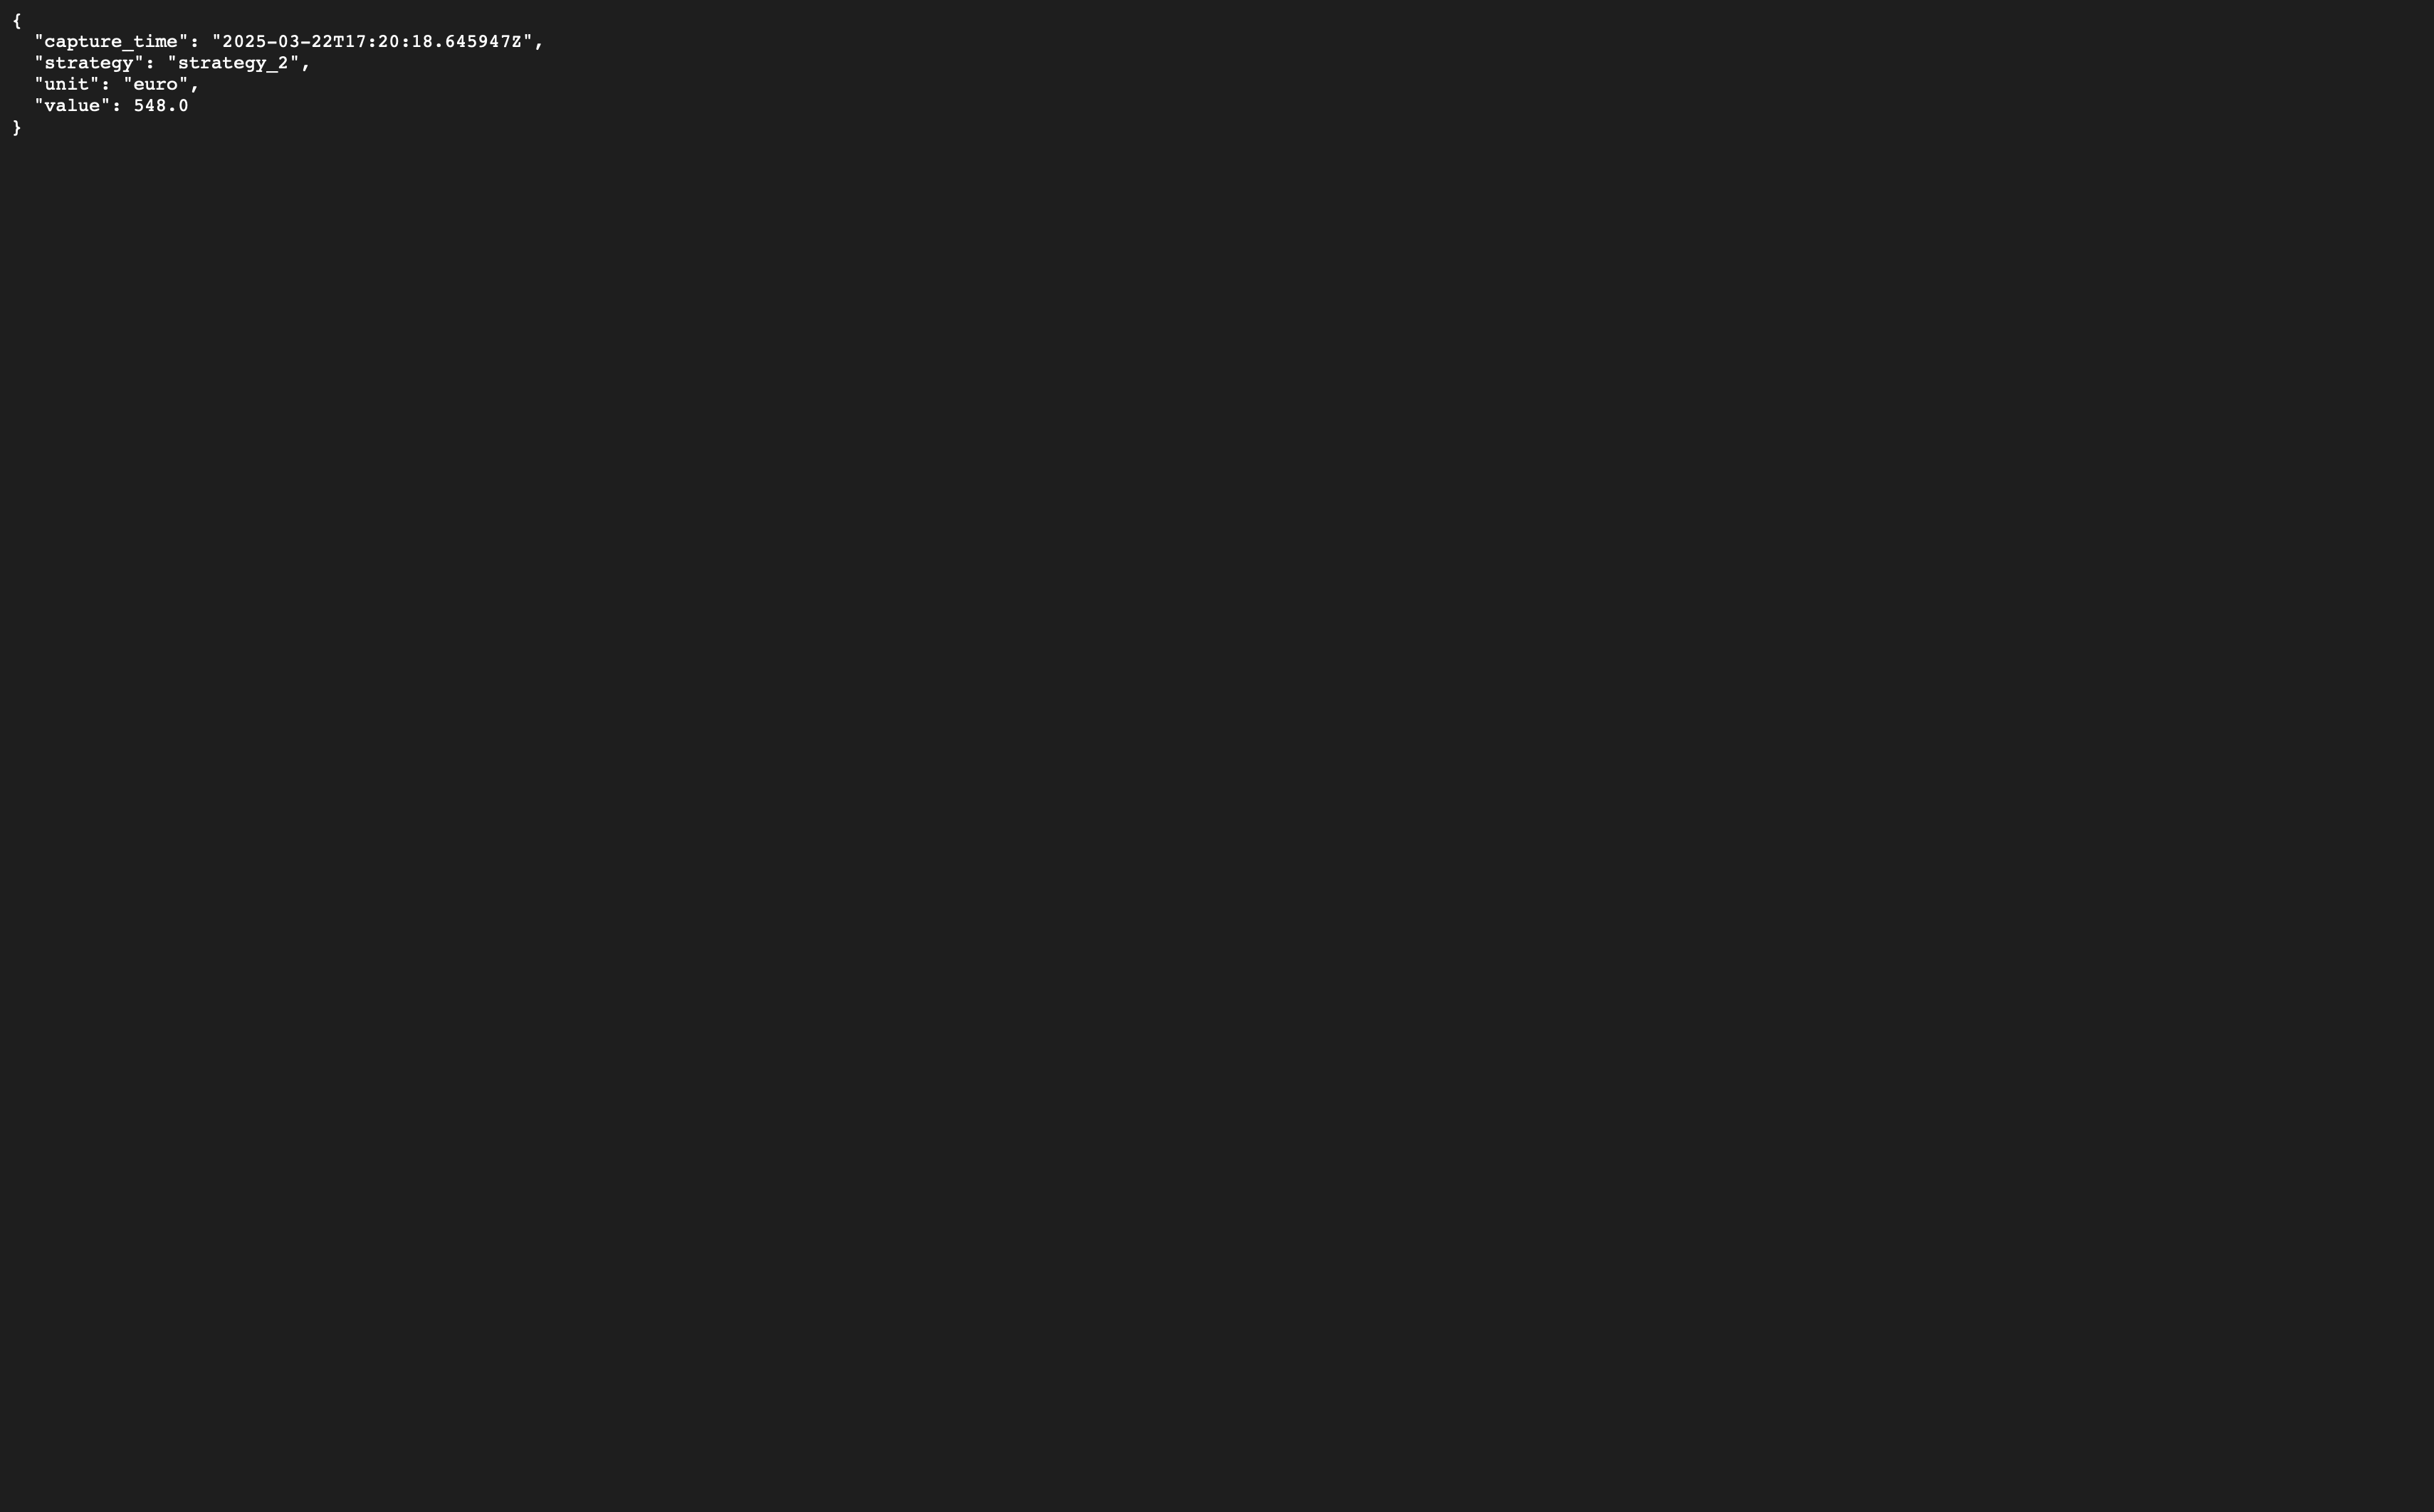

In [9]:
display(Image(filename='example_web.png'))

# Task 2: Data analysis and building a trading strategy

In [10]:
df = pd.read_excel("analysis_task_data.xlsx")
df.head(10)

,hour,time,Wind Day Ahead Forecast [in MW],Wind Intraday Forecast [in MW],PV Day Ahead Forecast [in MW],PV Intraday Forecast [in MW],Day Ahead Price hourly [in EUR/MWh],Intraday Price Price Quarter Hourly [in EUR/MWh],Intraday Price Hourly [in EUR/MWh],Imbalance Price Quarter Hourly [in EUR/MWh]
0,0,2021-01-01 00:00:00,4433,4709,0,0,50.87,44.409894,48.682294,13.33
1,0,2021-01-01 00:15:00,4286,4507,0,0,50.87,52.139142,48.682294,-0.92
2,0,2021-01-01 00:30:00,4142,4307,0,0,50.87,50.160255,48.682294,60.26
3,0,2021-01-01 00:45:00,3991,4181,0,0,50.87,41.342082,48.682294,-12.05
4,1,2021-01-01 01:00:00,3847,4094,0,0,48.19,64.424013,46.165819,96.09
5,1,2021-01-01 01:15:00,3728,3939,0,0,48.19,52.232320,46.165819,94.62
6,1,2021-01-01 01:30:00,3612,3705,0,0,48.19,45.797620,46.165819,92.21
7,1,2021-01-01 01:45:00,3508,3626,0,0,48.19,45.705681,46.165819,27.64
8,2,2021-01-01 02:00:00,3410,3585,0,0,44.68,65.529703,53.730263,13.71
9,2,2021-01-01 02:15:00,3303,3483,0,0,44.68,60.896307,53.730263,11.99


In [11]:
df.columns

Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   hour                                               35040 non-null  int64         
 1   time                                               35040 non-null  datetime64[ns]
 2   Wind Day Ahead Forecast [in MW]                    35040 non-null  int64         
 3   Wind Intraday Forecast [in MW]                     35040 non-null  int64         
 4   PV Day Ahead Forecast [in MW]                      35040 non-null  int64         
 5   PV Intraday Forecast [in MW]                       35040 non-null  int64         
 6   Day Ahead Price hourly [in EUR/MWh]                35040 non-null  float64       
 7   Intraday Price Price Quarter Hourly  [in EUR/MWh]  35040 non-null  float64       
 8   Intraday Price H

# Task 2.1
1) First, I select only the columns from 2021.
2) Then, I calculate the total MWh for each forecast type. To do this, I multiply all columns corresponding to each hour by 15/60.


In [13]:
df_2021 = df[df["time"].dt.year == 2021]
def format_column(col):
    if '[' in col:
        name_part, unit_part = col.split('[', 1)
        name_part = name_part.strip().replace(" ", "_")
        if name_part.endswith("_"):
            name_part = name_part[:-1]
        return f"{name_part}[{unit_part.strip()}"
    else:
        return col.strip().replace(" ", "_")
df_2021.columns = [format_column(col) for col in df_2021.columns]
df_2021

,hour,time,Wind_Day_Ahead_Forecast[in MW],Wind_Intraday_Forecast[in MW],PV_Day_Ahead_Forecast[in MW],PV_Intraday_Forecast[in MW],Day_Ahead_Price_hourly[in EUR/MWh],Intraday_Price_Price_Quarter_Hourly[in EUR/MWh],Intraday_Price_Hourly[in EUR/MWh],Imbalance_Price_Quarter_Hourly[in EUR/MWh]
0,0,2021-01-01 00:00:00,4433,4709,0,0,50.87,44.409894,48.682294,13.33
1,0,2021-01-01 00:15:00,4286,4507,0,0,50.87,52.139142,48.682294,-0.92
2,0,2021-01-01 00:30:00,4142,4307,0,0,50.87,50.160255,48.682294,60.26
3,0,2021-01-01 00:45:00,3991,4181,0,0,50.87,41.342082,48.682294,-12.05
4,1,2021-01-01 01:00:00,3847,4094,0,0,48.19,64.424013,46.165819,96.09
...,...,...,...,...,...,...,...,...,...,...
35035,22,2021-12-31 22:45:00,37367,33010,0,0,5.10,55.370243,59.268274,-25.16
35036,23,2021-12-31 23:00:00,37087,32409,0,0,6.32,86.602119,56.858157,-96.24
35037,23,2021-12-31 23:15:00,36786,32149,0,0,6.32,68.843006,56.858157,-137.24
35038,23,2021-12-31 23:30:00,36484,31755,0,0,6.32,42.875768,56.858157,-29.28


In [14]:
df_2021.columns

Index(['hour', 'time', 'Wind_Day_Ahead_Forecast[in MW]',
       'Wind_Intraday_Forecast[in MW]', 'PV_Day_Ahead_Forecast[in MW]',
       'PV_Intraday_Forecast[in MW]', 'Day_Ahead_Price_hourly[in EUR/MWh]',
       'Intraday_Price_Price_Quarter_Hourly[in EUR/MWh]',
       'Intraday_Price_Hourly[in EUR/MWh]',
       'Imbalance_Price_Quarter_Hourly[in EUR/MWh]'],
      dtype='object')

In [30]:
columns_of_weather_forecast = {'Wind_Day_Ahead_Forecast[in MW]',
       'Wind_Intraday_Forecast[in MW]', 'PV_Day_Ahead_Forecast[in MW]',
       'PV_Intraday_Forecast[in MW]'}

total_forecast_mwh = {}

for col in columns_of_weather_forecast:
    total_mwh = df_2021[col].sum() * 0.25
    total_forecast_mwh[col] = round(total_mwh, 2)

cleaned_forecast = {
    key.replace('_Forecast[in MW]', '').replace('Wind_', 'Wind ').replace('PV_', 'Solar '): value
    for key, value in total_forecast_mwh.items()
}

for source, mwh in cleaned_forecast.items():
    print(f"{source}: {mwh} MWh")

Solar Day_Ahead: 46094572.75 MWh
Wind Intraday: 113478034.5 MWh
Wind Day_Ahead: 115395406.25 MWh
Solar Intraday: 46689891.5 MWh


# Task 2.2
1) First, we extract the day from the timestamp.
2) Then, we calculate the average and plot the results.

In [16]:
df_2021['time_of_day'] = df_2021['time'].dt.time
avg_24h = df_2021.groupby('time_of_day')[list(columns_of_weather_forecast)].mean()
avg_24h.head(10)

,PV_Day_Ahead_Forecast[in MW],Wind_Intraday_Forecast[in MW],Wind_Day_Ahead_Forecast[in MW],PV_Intraday_Forecast[in MW]
time_of_day,,,,
00:00:00,0.0,13609.145205,13714.624658,0.0
00:15:00,0.0,13580.824658,13687.186301,0.0
00:30:00,0.0,13552.884932,13660.120548,0.0
00:45:00,0.0,13531.309589,13631.964384,0.0
01:00:00,0.0,13481.479452,13598.961644,0.0
01:15:00,0.0,13428.350685,13570.342466,0.0
01:30:00,0.0,13412.084932,13541.175342,0.0
01:45:00,0.0,13363.438356,13506.553425,0.0
02:00:00,0.0,13296.010959,13465.786301,0.0


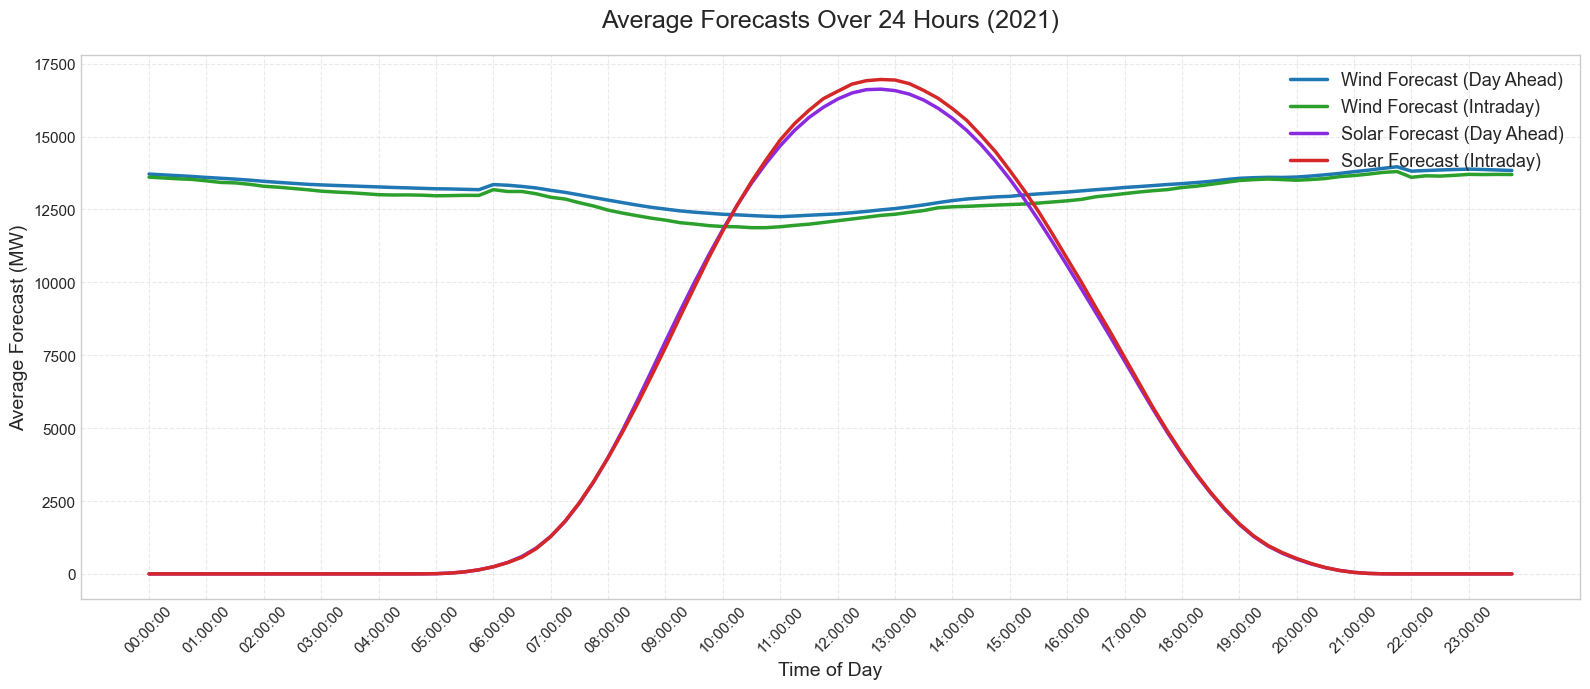

In [17]:
avg_24h.index = avg_24h.index.astype(str)

column_labels = {
    'Wind_Day_Ahead_Forecast[in MW]': 'Wind Forecast (Day Ahead)',
    'Wind_Intraday_Forecast[in MW]': 'Wind Forecast (Intraday)',
    'PV_Day_Ahead_Forecast[in MW]': 'Solar Forecast (Day Ahead)',
    'PV_Intraday_Forecast[in MW]': 'Solar Forecast (Intraday)'
}

custom_colors = {
    'Wind Forecast (Day Ahead)': '#1f77b4',    # blue
    'Wind Forecast (Intraday)': '#2ca02c',     # green
    'Solar Forecast (Day Ahead)': '#8A2BE2',   # violate
    'Solar Forecast (Intraday)': '#d62728'     # red
}

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 7))

for original_col, label in column_labels.items():
    plt.plot(avg_24h.index, avg_24h[original_col],
             label=label,
             color=custom_colors[label],
             linewidth=2.5)

plt.title("Average Forecasts Over 24 Hours (2021)", fontsize=18, pad=20)
plt.xlabel("Time of Day", fontsize=14)
plt.ylabel("Average Forecast (MW)", fontsize=14)

plt.xticks(
    ticks=range(0, len(avg_24h.index), 4),
    labels=[avg_24h.index[i] for i in range(0, len(avg_24h.index), 4)],
    rotation=45,
    fontsize=11
)

plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=13, loc='upper right')
plt.tight_layout()
plt.show()


# Task 2.3
1) To calculate the average value [in EUR/MWh], I need the sum of the wind forecast multiplied by the price, divided by the sum of the wind generation.
2) The wind forecast will be multiplied by 0.25, as in the first task.


In [18]:
avg_values = {}

for col in columns_of_weather_forecast:
    energy_mwh = df_2021[col] * 0.25
    revenue = energy_mwh * df_2021["Day_Ahead_Price_hourly[in EUR/MWh]"]
    avg_value = revenue.sum() / energy_mwh.sum()
    avg_values[col] = avg_value

avg_wind_value = avg_values["Wind_Day_Ahead_Forecast[in MW]"]
avg_pv_value = avg_values["PV_Day_Ahead_Forecast[in MW]"]
avg_da_price = df_2021["Day_Ahead_Price_hourly[in EUR/MWh]"].mean()

print("Average Wind Value (EUR/MWh):", avg_wind_value)
print("Average PV Value (EUR/MWh):", avg_pv_value)
print("Average Day-Ahead Price (EUR/MWh):", avg_da_price)


Average Wind Value (EUR/MWh): 81.38706977035753
Average PV Value (EUR/MWh): 76.89453079034125
Average Day-Ahead Price (EUR/MWh): 96.84991780821919


In [19]:
df_2021.columns

Index(['hour', 'time', 'Wind_Day_Ahead_Forecast[in MW]',
       'Wind_Intraday_Forecast[in MW]', 'PV_Day_Ahead_Forecast[in MW]',
       'PV_Intraday_Forecast[in MW]', 'Day_Ahead_Price_hourly[in EUR/MWh]',
       'Intraday_Price_Price_Quarter_Hourly[in EUR/MWh]',
       'Intraday_Price_Hourly[in EUR/MWh]',
       'Imbalance_Price_Quarter_Hourly[in EUR/MWh]', 'time_of_day'],
      dtype='object')

The average value for wind is 81 EUR/MWh and for PV 76 EUR/MWh, which is lower than the average day-ahead price value. The difference can be explained by the fact that renewable generation tends to be higher in specific hours (like solar during the day because of the sun), but prices in these periods are lower because we have an abundance of energy. Hence, because renewables are concentrated during lower-price periods, we get values that are lower than the average price (as it's an arithmetic value with high prices per hour). Also, it's called the `"cannibalization effect"` (high generation from renewables correlates with lower prices).

# Task 2.4
1) First, I need to compute the total renewable production (in MWh) per quarter-hour.
2) Then, find the daily total production.
3) Identify the highest and lowest production days.
4) Also, show the average day-ahead price for the corresponding day.



In [20]:
df_2021['date'] = df_2021['time'].dt.date

df_2021["Total_Renewable_energy_MWh"] = (df_2021["Wind_Day_Ahead_Forecast[in MW]"] + df_2021["PV_Day_Ahead_Forecast[in MW]"]) * 0.25

daily_renewable = df_2021.groupby('date')['Total_Renewable_energy_MWh'].sum()

max_day = daily_renewable.idxmax()
min_day = daily_renewable.idxmin()

print(f"Highest renewable day: {max_day} with {daily_renewable[max_day]:,.2f} MWh")
print(f"Lowest renewable day: {min_day} with {daily_renewable[min_day]:,.2f} MWh")

daily_prices = df_2021.groupby('date')['Day_Ahead_Price_hourly[in EUR/MWh]'].mean()

max_day_price = daily_prices[max_day]
min_day_price = daily_prices[min_day]

print(f"Avg DA Price on highest renewable day: {max_day_price:.2f} EUR/MWh")
print(f"Avg DA Price on lowest renewable day: {min_day_price:.2f} EUR/MWh")

Highest renewable day: 2021-03-12 with 1,088,041.00 MWh
Lowest renewable day: 2021-11-16 with 59,199.25 MWh
Avg DA Price on highest renewable day: 22.29 EUR/MWh
Avg DA Price on lowest renewable day: 237.47 EUR/MWh


We can see that the day with the highest renewable energy corresponds to a lower average price, whereas days with the lowest renewables correspond to higher day-ahead prices. There is a simple explanation: when there is an abundance of renewables in the energy market, it creates oversupply, which pushes prices down. When we don’t have enough renewable generation, energy becomes more valuable and scarce, which drives prices up due to undersupply in the market.

# Task 2.5

1) First, we need to identify the weekdays.
2) Then, compute the average.

In [21]:
df_2021['weekday'] = df_2021['time'].dt.weekday
df_2021["is_weekend"] = df_2021["weekday"].isin([5, 6])

avg_price_weekdays = df_2021.loc[~df_2021["is_weekend"], "Day_Ahead_Price_hourly[in EUR/MWh]"].mean()
avg_price_weekends = df_2021.loc[df_2021["is_weekend"], "Day_Ahead_Price_hourly[in EUR/MWh]"].mean()

print(f"Average DA Price on weekdays: {avg_price_weekdays:.2f} EUR/MWh")
print(f"Average DA Price on weekends: {avg_price_weekends:.2f} EUR/MWh")


Average DA Price on weekdays: 104.37 EUR/MWh
Average DA Price on weekends: 77.98 EUR/MWh


The average hourly day-ahead price during weekdays was 104.37 EUR/MWh, compared to only 77.98 EUR/MWh on weekends. This reflects a simple demand pattern in the energy market: during weekdays, all firms are operating—big corporations and industries—but during weekends, most people and large companies are not working. Hence, less energy is needed on non-working days.

# Task 2.6

The best strategy is to charge when prices are low and discharge when prices are high in the intraday market, as this allows us to take full advantage of the market’s volatility.

In [22]:
battery = 1.0
interval = int(battery / 0.25)

daily_revenue = []

for day in df_2021['time'].dt.date.unique():
    daily_data = df_2021[df_2021['time'].dt.date == day]
    prices = daily_data['Intraday_Price_Price_Quarter_Hourly[in EUR/MWh]'].values

    average_per_interval = [np.mean(prices[i:i + interval]) for i in range(len(prices) - interval + 1)]

    charge_price = min(average_per_interval)
    discharge_price = max(average_per_interval)

    revenue = (discharge_price - charge_price) * battery
    daily_revenue.append(revenue)

total_revenue = np.sum(daily_revenue)

print(f"Total revenue generated by 1 MWh battery in 2021: {total_revenue:.2f}")


Total revenue generated by 1 MWh battery in 2021: 37370.21


However, in a real-world setup, we do not know the exact maximum and minimum prices in advance. That’s why, in real time, it is more practical to charge the battery during the day—when renewable generation is high and prices are low—and discharge it in the evening, when there is typically an undersupply in the market and prices are higher.

Based on this logic, we can create a strategy where we charge the battery during the day using Day-Ahead prices, since by 14:00 the prices are already known, allowing for better planning and optimization of charging decisions.

Conversely, it is often better to sell (discharge) in the evening using Intraday prices, as the intraday market captures real-time volatility and price spikes, which can be leveraged for additional profitability.

In [23]:
daily_battery_revenue = []

for date, group in df_2021.groupby('date'):
    try:
        # Get charge price at 14:00 (ID) and discharge price at 19:00 (DA)
        charge_price = group[(group['hour'] == 14)]['Day_Ahead_Price_hourly[in EUR/MWh]'].values[0]
        discharge_price = group[(group['hour'] == 19)]['Intraday_Price_Hourly[in EUR/MWh]'].values[0]

        daily_profit = (discharge_price - charge_price) * battery
        daily_battery_revenue.append({
            'date': date,
            'charge_price': charge_price,
            'discharge_price': discharge_price,
            'daily_profit': daily_profit
        })
    except IndexError:
        continue

battery_df = pd.DataFrame(daily_battery_revenue)
battery_df['cumulative_profit'] = battery_df['daily_profit'].cumsum()

total_revenue_second_strategy = battery_df['daily_profit'].sum()
print(f"Total Battery Revenue for real-world setup (2021): €{total_revenue_second_strategy:,.2f}")




Total Battery Revenue for real-world setup (2021): €13,840.52


# Task 2.7

In [24]:
df_final = df.copy()
df_final.columns = [format_column(col) for col in df_final.columns]
df_final['hour'] = df_final['time'].dt.hour
df_final['weekday'] = df_final['time'].dt.day_name()
df_final['date'] = df_final['time'].dt.date
df_final['month'] = df_final['time'].dt.month
df_final['minute'] = df_final['time'].dt.minute
df_final.columns

Index(['hour', 'time', 'Wind_Day_Ahead_Forecast[in MW]',
       'Wind_Intraday_Forecast[in MW]', 'PV_Day_Ahead_Forecast[in MW]',
       'PV_Intraday_Forecast[in MW]', 'Day_Ahead_Price_hourly[in EUR/MWh]',
       'Intraday_Price_Price_Quarter_Hourly[in EUR/MWh]',
       'Intraday_Price_Hourly[in EUR/MWh]',
       'Imbalance_Price_Quarter_Hourly[in EUR/MWh]', 'weekday', 'date',
       'month', 'minute'],
      dtype='object')

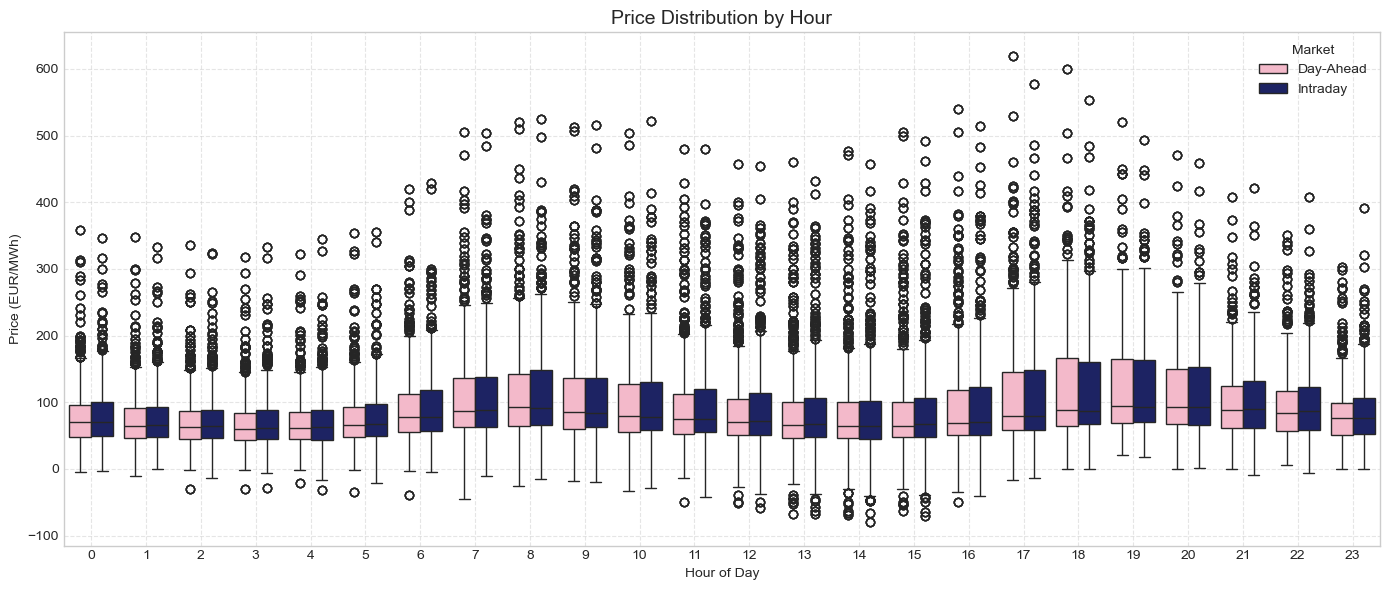

In [25]:
df_long = df_final[['hour', 'Day_Ahead_Price_hourly[in EUR/MWh]', 'Intraday_Price_Hourly[in EUR/MWh]']].copy()

df_long = df_long.melt(id_vars='hour',
                       value_vars=['Day_Ahead_Price_hourly[in EUR/MWh]', 'Intraday_Price_Hourly[in EUR/MWh]'],
                       var_name='Market', value_name='Price')

df_long['Market'] = df_long['Market'].replace({
    'Day_Ahead_Price_hourly[in EUR/MWh]': 'Day-Ahead',
    'Intraday_Price_Hourly[in EUR/MWh]': 'Intraday'
})

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_long, x='hour', y='Price', hue='Market', palette=['#fcb0c6', '#111a6f'])

plt.title("Price Distribution by Hour", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Price (EUR/MWh)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Market')
plt.tight_layout()
plt.show()

Form the boxplots, we can see that day-ahead and intraday prices are simular in distribution, but we can still see some patterns. For example, morning hours (7-10) and some evening hours (17, 20) show higher Intraday prices. This suggests opportunities to go long Day-Ahead and sell Intraday.

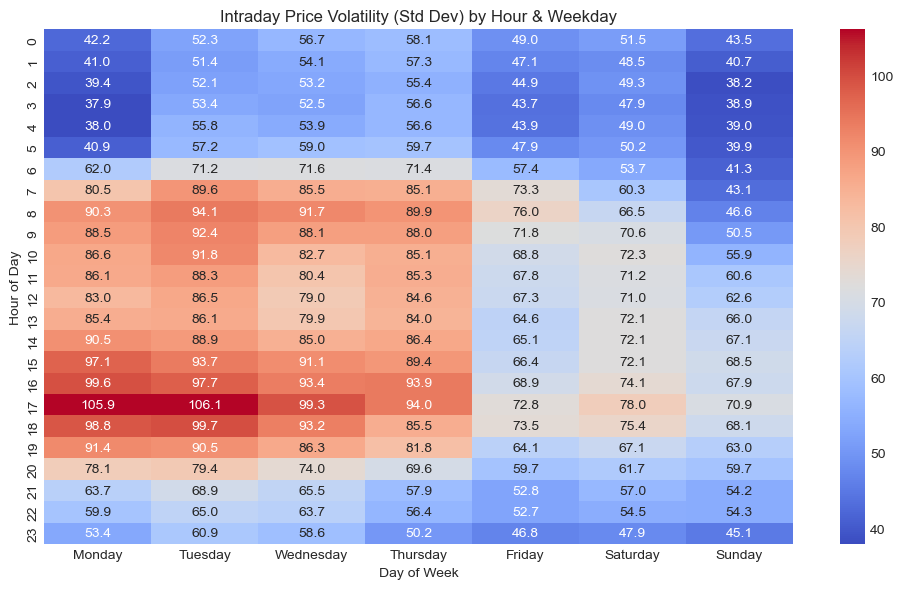

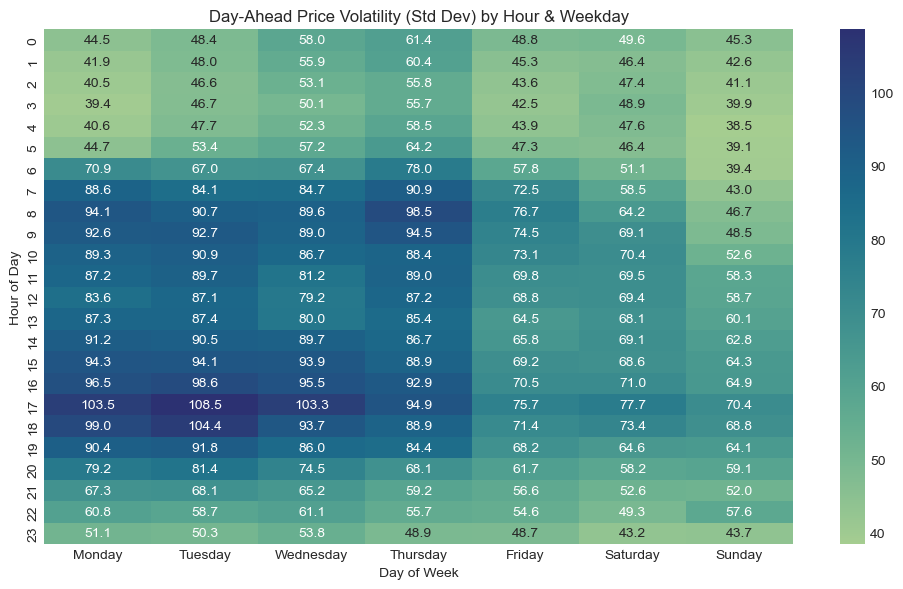

In [26]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_final['weekday'] = pd.Categorical(df_final['weekday'], categories=weekday_order, ordered=True)

pivot_vol_id = df_final.pivot_table( index='hour', columns='weekday', values='Intraday_Price_Hourly[in EUR/MWh]', aggfunc='std', observed=False)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_vol_id, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Intraday Price Volatility (Std Dev) by Hour & Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

pivot_vol_da = df_final.pivot_table(index='hour', columns='weekday', values='Day_Ahead_Price_hourly[in EUR/MWh]', aggfunc='std', observed=False)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_vol_da, cmap="crest", annot=True, fmt=".1f")
plt.title("Day-Ahead Price Volatility (Std Dev) by Hour & Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()



From the price volatility plot by day of the week, we can observe some patterns. Hours 18–20 show consistently higher Intraday prices compared to Day-Ahead, which is favorable for selling on the Intraday market—especially on weekdays. Hours 13–14 tend to have higher Day-Ahead prices, making them suitable for buying on Intraday and selling on Day-Ahead. On weekends, Intraday prices are usually higher than Day-Ahead prices.

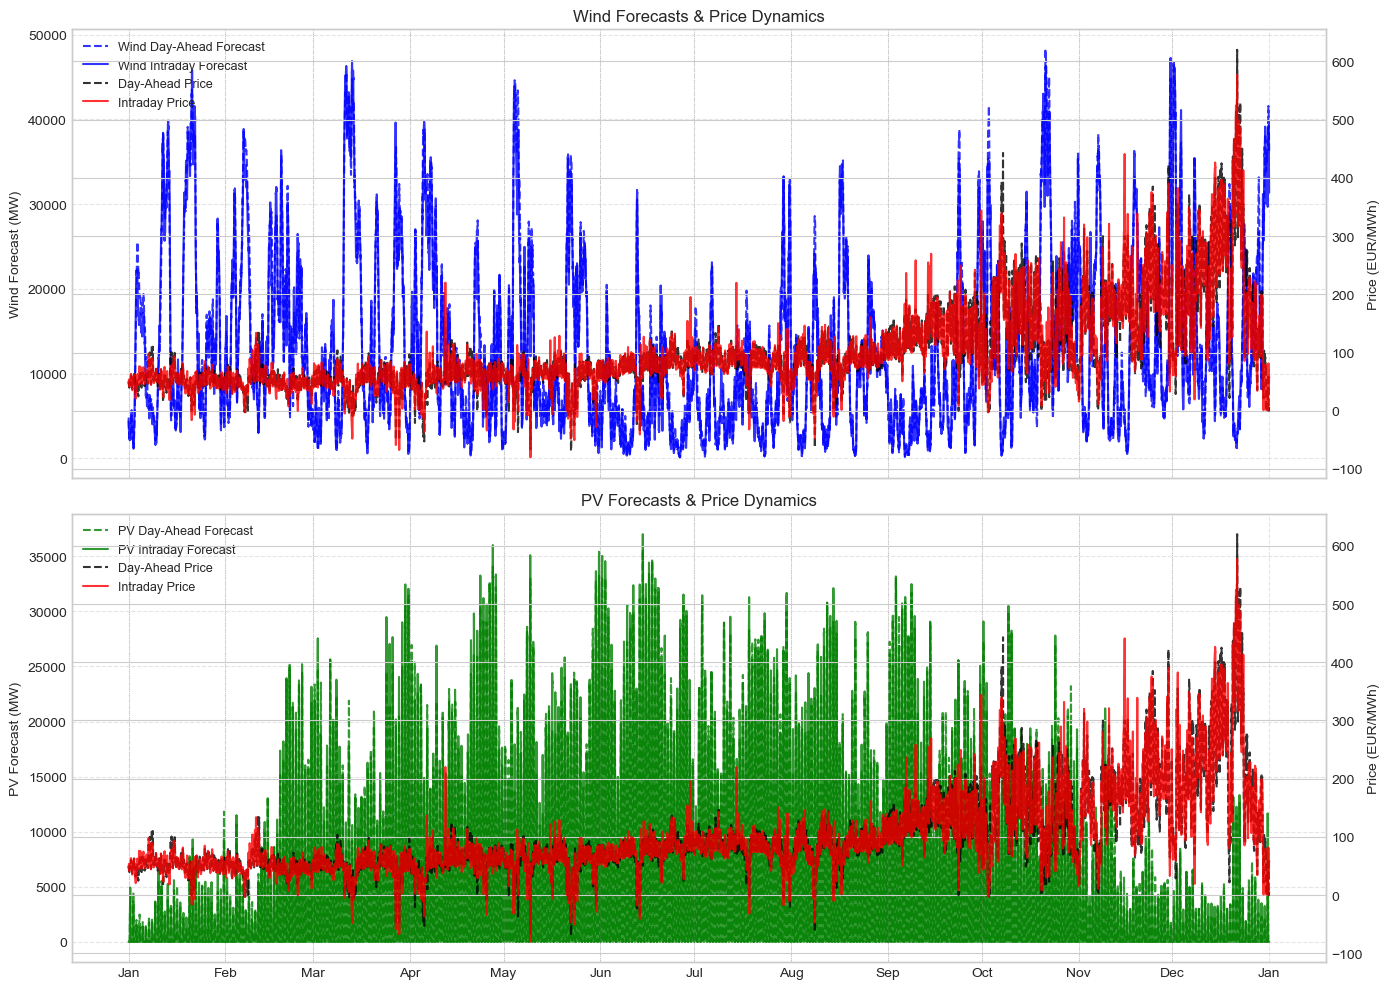

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax_wind = axes[0]
ax_wind_price = ax_wind.twinx()

# Plot wind forecasts
ax_wind.plot(df['time'], df_final['Wind_Day_Ahead_Forecast[in MW]'], label="Wind Day-Ahead Forecast", color="blue", linestyle="--", alpha=0.8)
ax_wind.plot(df['time'], df_final['Wind_Intraday_Forecast[in MW]'], label="Wind Intraday Forecast", color="blue", linestyle="-", alpha=0.8)

# Plot prices
ax_wind_price.plot(df['time'], df_final['Day_Ahead_Price_hourly[in EUR/MWh]'], label="Day-Ahead Price", color="black", linestyle="--", alpha=0.8)
ax_wind_price.plot(df['time'], df_final['Intraday_Price_Hourly[in EUR/MWh]'], label="Intraday Price", color="red", linestyle="-", alpha=0.8)

lines1, labels1 = ax_wind.get_legend_handles_labels()
lines2, labels2 = ax_wind_price.get_legend_handles_labels()
ax_wind.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=9)

ax_wind.set_title("Wind Forecasts & Price Dynamics", fontsize=12)
ax_wind.set_ylabel("Wind Forecast (MW)", fontsize=10)
ax_wind_price.set_ylabel("Price (EUR/MWh)", fontsize=10)
ax_wind.grid(True, linestyle="--", alpha=0.5)


ax_pv = axes[1]
ax_pv_price = ax_pv.twinx()

# Plot PV forecasts
ax_pv.plot(df['time'], df_final['PV_Day_Ahead_Forecast[in MW]'], label="PV Day-Ahead Forecast", color="green", linestyle="--", alpha=0.8)
ax_pv.plot(df['time'], df_final['PV_Intraday_Forecast[in MW]'], label="PV Intraday Forecast", color="green", linestyle="-", alpha=0.8)

# Plot prices
ax_pv_price.plot(df['time'], df_final['Day_Ahead_Price_hourly[in EUR/MWh]'], label="Day-Ahead Price", color="black", linestyle="--", alpha=0.8)
ax_pv_price.plot(df['time'], df_final['Intraday_Price_Hourly[in EUR/MWh]'], label="Intraday Price", color="red", linestyle="-", alpha=0.8)

lines3, labels3 = ax_pv.get_legend_handles_labels()
lines4, labels4 = ax_pv_price.get_legend_handles_labels()
ax_pv.legend(lines3 + lines4, labels3 + labels4, loc="upper left", fontsize=9)

ax_pv.set_title("PV Forecasts & Price Dynamics", fontsize=12)
ax_pv.set_ylabel("PV Forecast (MW)", fontsize=10)
ax_pv_price.set_ylabel("Price (EUR/MWh)", fontsize=10)
ax_pv.grid(True, linestyle="--", alpha=0.5)


locator = mdates.MonthLocator()
formatter = mdates.DateFormatter("%b")
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)

start_date = df['time'].min()
end_date = df['time'].max()
for month_start in pd.date_range(start=start_date, end=end_date, freq='MS'):
    for ax in axes:
        ax.axvline(month_start, color='gray', linestyle=':', linewidth=0.5, alpha=0.7)

plt.xlabel("Time", fontsize=10)
plt.tight_layout()
plt.show()


We have already plotted average forecast hours in Task 2.2 and explained the cannibalization effect — the phenomenon where an abundance of renewable resources during the day drives prices down. Now, let’s analyze the forecast plots by season. As we can see, wind forecasts are volatile and negatively correlated with prices. In winter, wind spikes are more frequent, and price drops are sharper. When the wind forecast is very low, prices tend to rise, so it's safer to buy in the Day-Ahead market and sell in the Intraday market. When PV production is high, prices often drop due to oversupply. Since this is a consistent pattern, we can take advantage by buying in the Intraday market and selling during peak Day-Ahead hours.

## Strategy

1) First, we check volatility in prices for the previous day. If the daily price range in the DA market is very high (more than 100 euros), it's better to play safe and buy on DA.

2) If recent volatility is detected between 3 lags (in DA or ID) with price jumps more than 20 euros, it's better to go long-term.

3) If the wind forecast is high, we expect oversupply and can use ID prices to buy due to lower price.

4) If the solar forecast is very high and it's midday, prices are likely to drop and we can buy ID.

5) If solar is extremely low or moderately low, but it's winter, there will be undersupply — we need to buy DA, sell ID.

6) If the error in forecasting of solar or wind is large, it's better to play safe and buy DA.

7) If wind error is negative or solar error is negative, then we overestimated renewables — there can be a drop in prices, so we can buy ID at a lower price.

8) Then, we have weekday patterns that I've already described. Evening weekdays and weekends are better to sell ID; middays are better to buy ID (because of the abundance of renewables).


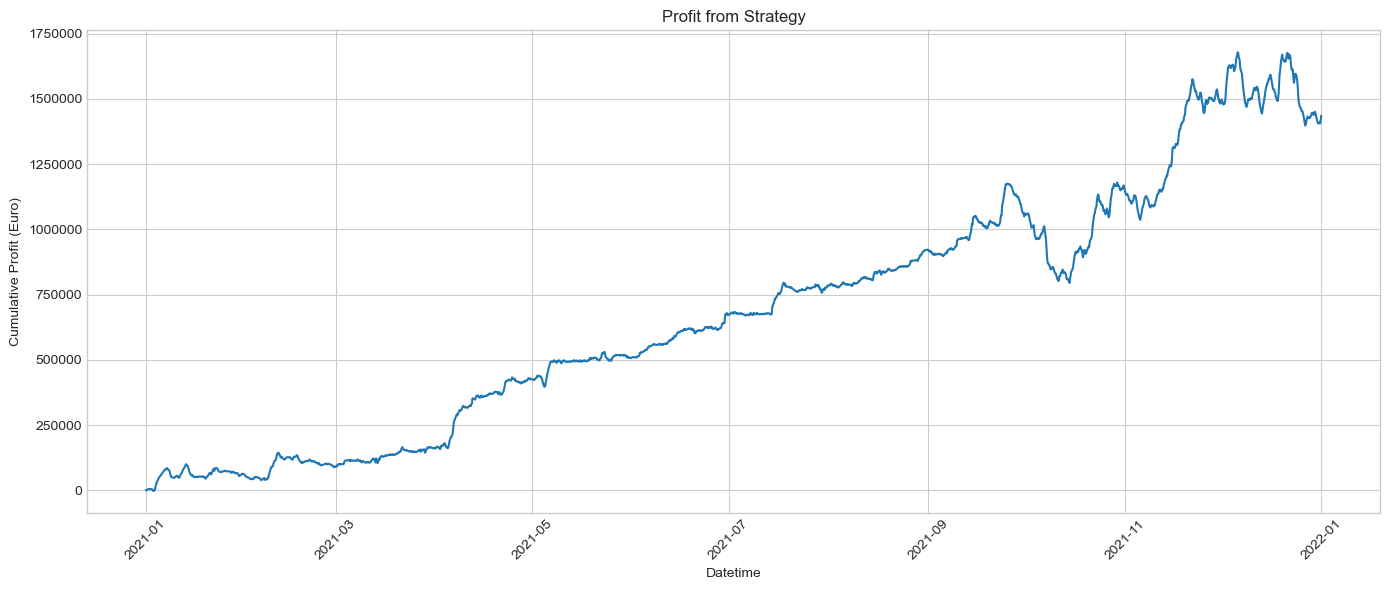

Total Profit: 1,436,113.23
Profit per MWh: 1.64


In [28]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'shoulder'


def define_weekday_hour_strategy():
    strategy = {}
    rules = {
        'Monday': ([8, 9, 16, 17, 18], [11, 12, 13]),
        'Tuesday': ([15, 16, 17, 18], [12, 13, 14]),
        'Wednesday': ([13, 14, 15, 16], [11, 12]),
        'Thursday': ([7, 8, 9, 10], [12, 13]),
        'Friday': ([8, 9, 16, 17], [13, 14])
    }

    for day, (da_sell_hours, da_buy_hours) in rules.items():
        for h in range(24):
            key = f"{day}_{h:02d}"
            if h in da_sell_hours:
                strategy[key] = {'buy_market': 'DA', 'sell_market': 'ID'}
            elif h in da_buy_hours:
                strategy[key] = {'buy_market': 'ID', 'sell_market': 'DA'}
            else:
                strategy[key] = {'buy_market': 'DA', 'sell_market': 'ID'}

    for day in ['Saturday', 'Sunday']:
        for h in range(24):
            key = f"{day}_{h:02d}"
            strategy[key] = {'buy_market': 'DA', 'sell_market': 'ID'}

    return strategy


def simulate_strategy(df):
    df = df[df['minute'] == 0].copy()
    df = df.sort_values('time')
    df['season'] = df['month'].apply(get_season)

    for lag in range(1, 24):
        df[f'DA_price_lag_{lag}'] = df['Day_Ahead_Price_hourly[in EUR/MWh]'].shift(lag)
        df[f'ID_price_lag_{lag}'] = df['Intraday_Price_Hourly[in EUR/MWh]'].shift(lag)

    df['DA_range_24h'] = df['Day_Ahead_Price_hourly[in EUR/MWh]'].rolling(24).apply(lambda x: x.max() - x.min(), raw=True)

    strategy_map = define_weekday_hour_strategy()
    results = []

    for _, row in df.iterrows():
        hour = row['hour']
        weekday = row['weekday']
        season = row['season']
        wind_forecast = row['Wind_Day_Ahead_Forecast[in MW]']
        pv_forecast = row['PV_Day_Ahead_Forecast[in MW]']
        pv_error = pv_forecast - row['PV_Intraday_Forecast[in MW]']
        wind_error = wind_forecast - row['Wind_Intraday_Forecast[in MW]']
        key = f"{weekday}_{hour:02d}"

        # Volatility checks
        da_volatility_flag = any(
            pd.notna(row[f'DA_price_lag_{i}']) and pd.notna(row[f'DA_price_lag_{i+1}']) and
            abs(row[f'DA_price_lag_{i}'] - row[f'DA_price_lag_{i+1}']) > 20
            for i in range(1, 3)
        )
        id_volatility_flag = any(
            pd.notna(row[f'ID_price_lag_{i}']) and pd.notna(row[f'ID_price_lag_{i+1}']) and
            abs(row[f'ID_price_lag_{i}'] - row[f'ID_price_lag_{i+1}']) > 20
            for i in range(1, 3)
        )

        # Decision rules
        if row.get('DA_range_24h', 0) > 100:
            strategy = {'buy_market': 'DA', 'sell_market': 'ID'}
        elif da_volatility_flag or id_volatility_flag:
            strategy = {'buy_market': 'DA', 'sell_market': 'ID'}
        elif wind_forecast > 50000:
            strategy = {'buy_market': 'ID', 'sell_market': 'DA'}
        elif pv_forecast > 30000 and hour in [11, 12, 13, 14]:
            strategy = {'buy_market': 'ID', 'sell_market': 'DA'}
        elif pv_forecast < 5000 or (pv_forecast < 10000 and season == 'winter'):
            strategy = {'buy_market': 'DA', 'sell_market': 'ID'}
        elif pv_error > 1000:
            strategy = {'buy_market': 'DA', 'sell_market': 'ID'}
        elif wind_error > 1000:
            strategy = {'buy_market': 'DA', 'sell_market': 'ID'}
        elif wind_error < -10:
            strategy = {'buy_market': 'ID', 'sell_market': 'DA'}
        elif pv_error < -10 and hour in [10, 11, 12, 13, 14]:
            strategy = {'buy_market': 'ID', 'sell_market': 'DA'}
        else:
            strategy = strategy_map.get(key, {'buy_market': 'DA', 'sell_market': 'ID'})

        buy_price = row['Day_Ahead_Price_hourly[in EUR/MWh]'] if strategy['buy_market'] == 'DA' else row['Intraday_Price_Hourly[in EUR/MWh]']
        sell_price = row['Day_Ahead_Price_hourly[in EUR/MWh]'] if strategy['sell_market'] == 'DA' else row['Intraday_Price_Hourly[in EUR/MWh]']
        profit = (sell_price - buy_price) * 100

        results.append({
            'datetime': row['time'],
            'hour': hour,
            'weekday': weekday,
            'season': season,
            'buy_market': strategy['buy_market'],
            'sell_market': strategy['sell_market'],
            'buy_price': buy_price,
            'sell_price': sell_price,
            'profit': profit
        })

    return pd.DataFrame(results)


results_df = simulate_strategy(df_final)
results_df['cumulative_profit'] = results_df['profit'].cumsum()

plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=results_df, x='datetime', y='cumulative_profit')
ax.set_title("Profit from Strategy")
ax.set_xlabel("Datetime")
ax.set_ylabel("Cumulative Profit (Euro)")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_profit = results_df['profit'].sum()
print(f"Total Profit: {total_profit:,.2f}")
profit_per_mwh = total_profit / (100 * len(results_df))
print(f"Profit per MWh: {profit_per_mwh:.2f}")


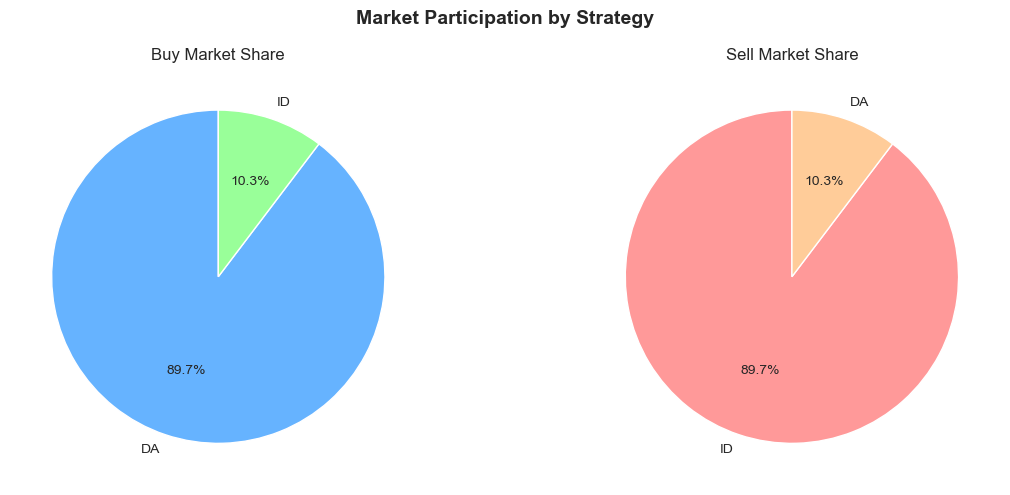

In [29]:
buy_counts = results_df['buy_market'].value_counts()
sell_counts = results_df['sell_market'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pie(buy_counts, labels=buy_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
axes[0].set_title("Buy Market Share")

axes[1].pie(sell_counts, labels=sell_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#ffcc99'])
axes[1].set_title("Sell Market Share")

plt.suptitle("Market Participation by Strategy", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()#


I think it's a good enough strategy. The strategy accumulates profit steadily across the year, and we can see a linear pattern. I believe it reflects well how real-world electricity markets behave — with volatility, renewables-driven dips, evening ramps, and forecast errors. But maybe a more dynamic model could be implemented to add more conditions where we buy in the short term and sell in the long term.

Still, I guess for safety and profit, it's better to buy day-ahead prices. It's always a trade-off between using the market’s changing nature to capture price swings and hedging. For further improvement, it would be interesting to implement some machine learning, include more path values, and assign weights based on important rules (like oversupply during day hours being more important than forecast error).
